# Diabetic Retinopathy Detection – Phase 3: Model Experimentation

### 🎯 **Objective**
The goal of this notebook is to rapidly prototype and evaluate several different Convolutional Neural Network (CNN) architectures to identify the most effective approach for our DR classification task. This phase is about breadth over depth; we will train baseline versions of each model to compare their performance and select a winning architecture for intensive fine-tuning in the final phase.

The insights from our EDA in Phase 2 will be directly implemented here, specifically addressing the challenges of class imbalance and the need for a powerful model architecture.

---

### 🧾 **Business Rationale (Senior BA Perspective)**
This phase represents the core of our technical de-risking strategy. Having curated and understood our data asset, we now enter the solution-finding stage. From a business standpoint, this is not about building the final, perfect model; it's about **making an informed technology selection**.

By experimenting with multiple architectures—from a simple custom CNN to complex pre-trained models like ResNet and EfficientNet—we will generate the comparative performance data needed to justify our final architectural choice. This evidence-based approach is critical for managing project resources effectively. It ensures that when we proceed to the final, computationally expensive training phase, we are investing in the most promising and highest-potential solution, thereby maximizing our chances of a successful PoC.


In [18]:
# Import necessary libraries and cleaned metadata

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Configuration ---
METADATA_PATH = "Data/aptos2019-blindness-detection/clean_metadata.csv"
IMG_SIZE = 224 # A standard size for many pre-trained models
BATCH_SIZE = 32
EPOCHS = 10 # A smaller number for rapid experimentation
NUM_CLASSES = 5 # We have 5 diagnosis levels (0-4)

# --- Load Data ---
try:
    df = pd.read_csv(METADATA_PATH)
    # Ensure the diagnosis column is treated as a string for the generator
    df['diagnosis'] = df['diagnosis'].astype(str)
    print(f"✅ Successfully loaded clean metadata from: {METADATA_PATH}")
    print(f"Dataset contains {len(df)} verified images.")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find the metadata file at {METADATA_PATH}")
    print("Please ensure you have successfully run the '01_preprocess.py' script first.")
    df = pd.DataFrame()

if not df.empty:
    print("\nData loaded and ready for splitting.")
    print(df.info())

✅ Successfully loaded clean metadata from: Data/aptos2019-blindness-detection/clean_metadata.csv
Dataset contains 3534 verified images.

Data loaded and ready for splitting.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id_code          3534 non-null   object
 1   diagnosis        3534 non-null   object
 2   filepath         3534 non-null   object
 3   diagnosis_label  3534 non-null   object
dtypes: object(4)
memory usage: 110.6+ KB
None


### Step 2: Create Stratified Training and Validation Splits

Based on our EDA findings, a simple random split of the data is inappropriate due to the severe class imbalance. We will perform a **stratified split**, which ensures that the proportion of images in each diagnostic class is the same in both our training and validation sets. This is crucial for training a reliable model and getting a trustworthy evaluation of its performance.
### -----------------------------------------------------------------------------
#### ACTION: Split the DataFrame into training (80%) and validation (20%) sets.
### -----------------------------------------------------------------------------
**Rationale**: We create separate DataFrames for training and validation. The model will only learn from the `train_df`. The `val_df` will be used as an unseen dataset to evaluate the model's performance after each epoch, helping us monitor for overfitting.

In [19]:
if not df.empty:
    # We use the 'diagnosis' column as the basis for stratification.
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,       # 20% of the data will be used for validation
        random_state=42,     # Ensures the split is reproducible
        stratify=df['diagnosis'] # The key to preserving class proportions
    )

    print(f"Training set size: {len(train_df)} images")
    print(f"Validation set size: {len(val_df)} images")

    # Optional: Verify the distribution in each split
    print("\nTraining set distribution:")
    print(train_df['diagnosis'].value_counts(normalize=True))
    print("\nValidation set distribution:")
    print(val_df['diagnosis'].value_counts(normalize=True))

Training set size: 2827 images
Validation set size: 707 images

Training set distribution:
diagnosis
0    0.508666
2    0.264238
1    0.096569
4    0.078882
3    0.051645
Name: proportion, dtype: float64

Validation set distribution:
diagnosis
0    0.509194
2    0.264498
1    0.096181
4    0.079208
3    0.050919
Name: proportion, dtype: float64


### Set Up Data Augmentation and Generators

Data augmentation is a critical technique to combat overfitting and partially mitigate the effects of our class imbalance. We will apply random transformations (like rotation, zoom, and flips) to the training images. This artificially expands our dataset, forcing the model to learn more robust and generalizable features.

Crucially, we will **not** augment the validation data. We need a consistent, unaltered benchmark to get a true measure of our model's performance.
#### -----------------------------------------------------------------------------
#### ACTION: Create Keras ImageDataGenerators for training and validation.
#### -----------------------------------------------------------------------------
#### Rationale:
The ImageDataGenerator is a highly efficient tool that loads images from the disk in batches, processes them, and feeds them to the model. This avoids loading the entire dataset into RAM.

In [20]:
if not df.empty:
    # 1. Create a generator for the TRAINING data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,         # Normalize pixel values to [0, 1]
        rotation_range=20,      # Randomly rotate images
        width_shift_range=0.1,  # Randomly shift images horizontally
        height_shift_range=0.1, # Randomly shift images vertically
        shear_range=0.1,        # Apply shear transformations
        zoom_range=0.1,         # Randomly zoom in on images
        horizontal_flip=True,   # Randomly flip images horizontally
        fill_mode='nearest'
    )

    # 2. Create a generator for the VALIDATION data (only rescaling)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # 3. Create the actual data iterators from our DataFrames
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='diagnosis',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical' # For multi-class classification
    )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filepath',
        y_col='diagnosis',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False # No need to shuffle validation data
    )

    print("\n✅ Data generators created successfully.")

Found 2827 validated image filenames belonging to 5 classes.
Found 707 validated image filenames belonging to 5 classes.

✅ Data generators created successfully.


### Experiment 1 - Build and Train a Baseline CNN

Our first experiment is to build a simple CNN from scratch. This model will establish our performance baseline. It will consist of a few convolutional and pooling layers to extract features, followed by dense layers for classification. This approach helps us understand the minimum performance we can expect on this complex task before introducing more powerful, pre-trained models.
**ACTION: Define, compile, and train a simple sequential CNN model.**

We use a Sequential model for its simplicity. The architecture starts with convolutional layers to learn spatial hierarchies of features. Dropout layers are included to prevent overfitting. The final layer uses a 'softmax' activation function, which is standard for multi-class classification as it outputs a probability distribution across the classes.

In [21]:
if not df.empty:
    baseline_model = Sequential([
        # Input layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),

        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Third convolutional layer
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Flatten the feature maps and feed to dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5), # Dropout for regularization

        # Output layer
        Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compile the model
    baseline_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    baseline_model.summary()

    # Train the model
    print("\n--- Training Baseline CNN ---")
    history_baseline = baseline_model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)
    )

    print("\n✅ Baseline model training complete.")

C:\Users\Kiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Baseline CNN ---


C:\Users\Kiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.6123 - loss: 1.0507 - val_accuracy: 0.6959 - val_loss: 0.9648
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.7078 - loss: 0.8687 - val_accuracy: 0.7086 - val_loss: 0.8677
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.7174 - loss: 0.8270 - val_accuracy: 0.7129 - val_loss: 0.8020
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.7188 - loss: 0.8272 - val_accuracy: 0.7100 - val_loss: 0.8782
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 442s 5s/step - accuracy: 0.7195 - loss: 0.8192 - val_accuracy: 0.7185 - val_loss: 0.8253
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.7241 - loss: 0.8130 - val_accuracy: 0.7171 - val_loss: 0.7926
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.7213 - loss: 0.8230 - val_accuracy: 0.7199 - val_loss: 0.7913
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - accuracy: 0.7276 - loss: 0.7934 - val_accuracy: 0.7157 - v

### Visualize Baseline Model Performance

After training, it's crucial to visualize the model's performance to understand its learning dynamics. We will plot the training and validation accuracy and loss over each epoch. These plots are essential for diagnosing issues like **overfitting** (where the model performs well on training data but poorly on validation data) or **underfitting** (where the model fails to learn effectively on either).

#### Rationale:
Visualizing the history object allows for a quick and intuitive assessment of the model's training process. A diverging gap between training and validation curves is a clear sign of overfitting.

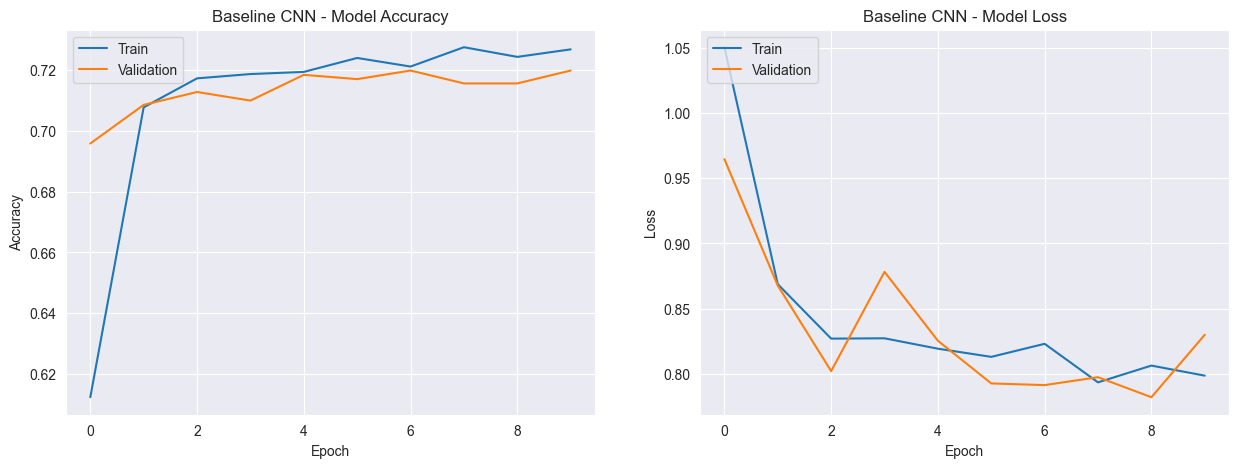

In [22]:
if 'history_baseline' in locals():
    def plot_history(history, title):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot training & validation accuracy values
        ax1.plot(history.history['accuracy'])
        ax1.plot(history.history['val_accuracy'])
        ax1.set_title(f'{title} - Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title(f'{title} - Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'], loc='upper left')

        plt.show()

    plot_history(history_baseline, "Baseline CNN")

### Experiment 2 - Transfer Learning with ResNet50

The baseline model's performance was limited, indicating it was not powerful enough to capture the complex features of the retinal images (a classic case of underfitting). Our next experiment will use **transfer learning**. We will leverage the **ResNet50** model, which has been pre-trained on the massive ImageNet dataset. By using its learned features as a starting point, we hypothesize a significant performance improvement.

Our strategy is to:
1.  Load the pre-trained ResNet50 model without its final classification layer.
2.  **Freeze** the weights of the ResNet50 layers so they don't change during initial training.
3.  Add our own custom classification "head" on top of the frozen base.
4.  Train only our new custom layers.

This approach allows us to benefit from the powerful, general-purpose feature extractors learned by ResNet50. By freezing the base, we prevent these robust weights from being destroyed by large, random gradients during the initial training epochs. We only train our small, new classifier, which is a much faster and more stable process.

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

if not df.empty:
    # 1. Load the pre-trained ResNet50 model
    base_model = ResNet50(
        weights='imagenet',      # Load weights pre-trained on ImageNet
        include_top=False,       # Do NOT include the final ImageNet classifier layer
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # 2. Freeze the base model
    base_model.trainable = False

    # 3. Create the new model on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # A layer to average the features
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    resnet_model = Model(inputs=base_model.input, outputs=predictions)

    # 4. Compile the model
    resnet_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    resnet_model.summary()

    # 5. Train the model
    print("\n--- Training ResNet50 Transfer Learning Model ---")
    history_resnet = resnet_model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)
    )

    print("\n✅ ResNet50 model training complete.")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training ResNet50 Transfer Learning Model ---
Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.4581 - loss: 1.4398 - val_accuracy: 0.5092 - val_loss: 1.2606
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 502s 6s/step - accuracy: 0.4952 - loss: 1.3016 - val_accuracy: 0.5092 - val_loss: 1.2592
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 506s 6s/step - accuracy: 0.5076 - loss: 1.2897 - val_accuracy: 0.5092 - val_loss: 1.2581
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 497s 6s/step - accuracy: 0.5076 - loss: 1.2890 - val_accuracy: 0.5092 - val_loss: 1.2461
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 486s 5s/step - accuracy: 0.5076 - loss: 1.2779 - val_accuracy: 0.5092 - val_loss: 1.2440
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 497s 6s/step - accuracy: 0.5087 - loss: 1.2735 - val_accuracy: 0.5092 - val_loss: 1.2374
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 492s 6s/step - accuracy: 0.5087 - loss: 1.2749 - val_accuracy: 0.5092 - val_loss: 1.2425
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accurac

KeyboardInterrupt: 

In [ ]:
# Visualize ResNet50 Model Performance

# Just as we did with our baseline, we will now visualize the performance of the ResNet50 model.This will allow us to directly compare its learning dynamics and see if transfer learning has led to faster convergence and better overall accuracy.
# -----------------------------------------------------------------------------
# ACTION: Plot accuracy and loss curves for the ResNet50 model.
# -----------------------------------------------------------------------------
# We reuse our plotting function to maintain consistency in our reporting. This visual comparison is the clearest way to demonstrate the effectiveness of transfer learning compared to our baseline model.

if 'history_resnet' in locals():
    plot_history(history_resnet, "ResNet50 Transfer Learning")